In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

## MA

In [2]:
data = pd.read_csv("widget_sales.csv")
adfuller(data['widget_sales'])[1]

0.5274845352272631

In [3]:
data_diff = data.diff().dropna()
adfuller(data_diff['widget_sales'])[1]

7.076922818587346e-19

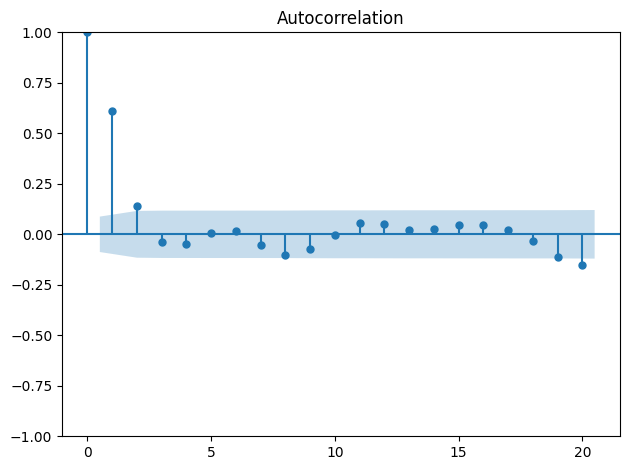

In [4]:
plot_acf(data_diff, lags=20);
plt.tight_layout()

In [30]:
def rolling_predict(data: pd.DataFrame,
                    train_size: int,
                    forward_size: int,
                    method='sarimax',
                    **kwargs):
    """
    Rolling prediction

    Args:
        data (pd.DataFrame): data
        train_size (int): train size
        forward_size (int): window size; number of forecasts at each step
        method (str, optional): method. Defaults to 'sarimax'.


    Returns:
        list: predictions
    """
    # to not be the dimension of the data or the index, turn it into a numpy array
    if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
        tseries = data.values.ravel()
    elif isinstance(data, np.ndarray):
        tseries = data.ravel()
    else:
        raise ValueError("data must be a pandas DataFrame, Series or numpy array")

    # number of steps to forecast
    horizon = len(tseries) - train_size
    total_length = train_size + horizon

    predictions = []
    for i in range(train_size, total_length, forward_size):
        model = SARIMAX(tseries[:i], order=kwargs['order']).fit(disp=False)
        # both start and end are inclusive so we need to subtract 1
        # here, i refers to the index as well; we trained the model using data[:i] so we need to start predicting from i
        pred = model.get_prediction(start=i, end=i + forward_size - 1).predicted_mean
        predictions.extend(pred)


    # convert to pandas Series for convenience the index can be better managed
    tseries = pd.Series(tseries)
    predictions = pd.Series(predictions, index=tseries[train_size:].index)

    return tseries, predictions

In [9]:
true, pred = rolling_predict(
    data_diff, train_size=449, forward_size=1, **{"order": (2, 0, 2)}
)

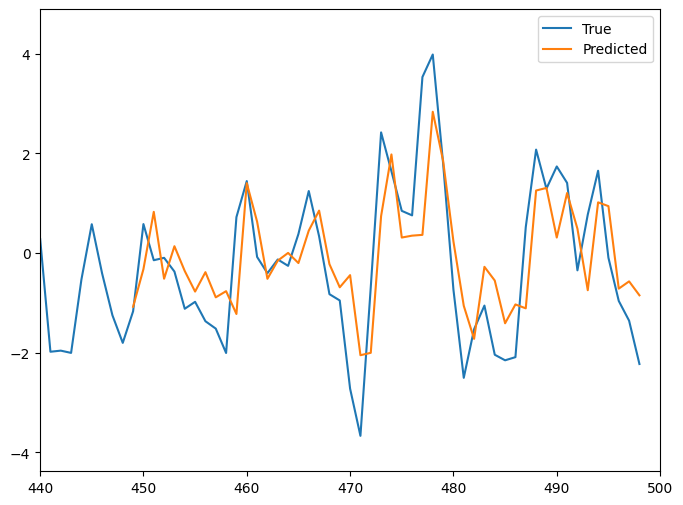

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true, label='True')
ax.plot(pred, label='Predicted')
ax.set_xlim(440, 500)
ax.legend()

In [11]:
from sklearn.metrics import mean_squared_error

mean_squared_error(pred, data_diff[449:])

1.1214364789178222

## AR

In [51]:
df = pd.read_csv("foot_traffic.csv")
foot_traffic_diff = np.diff(df['foot_traffic'])

In [52]:
ADF_result = adfuller(foot_traffic_diff)
adfuller(foot_traffic_diff)[1]

6.369317654781405e-06

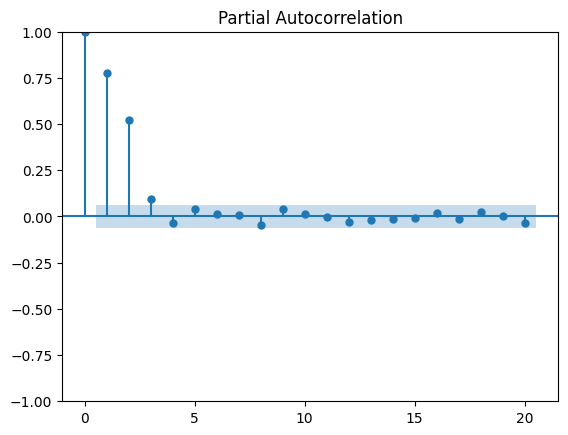

In [53]:
plot_pacf(foot_traffic_diff, lags=20);

In [133]:
true, pred = rolling_predict(data=foot_traffic_diff, train_size=947, forward_size=1, **{"order": (3, 0, 0)})

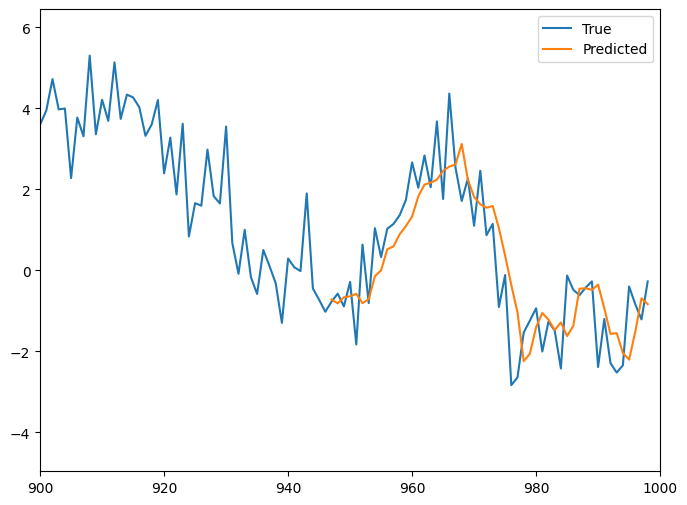

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true, label='True')
ax.plot(pred, label='Predicted')
ax.set_xlim(900, 1000)
ax.legend()

In [62]:
mean_squared_error(pred, foot_traffic_diff[947:])

0.9242479163440505

In [143]:
df['pred'] = (df['foot_traffic'][947:] + pred).shift(1).dropna()

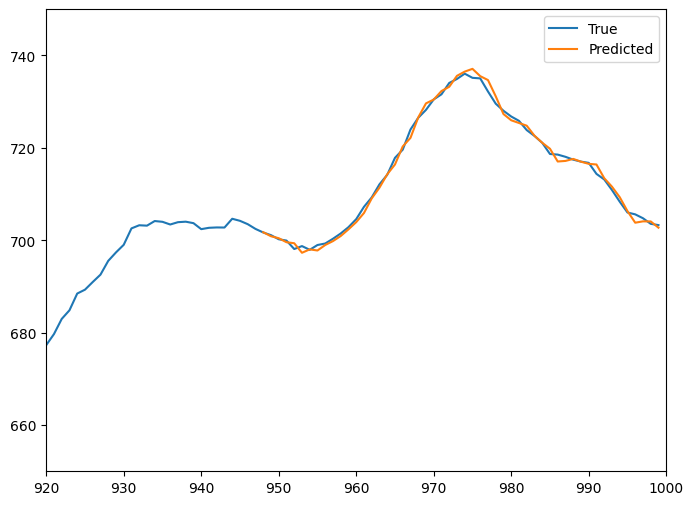

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['foot_traffic'], label='True')
ax.plot(df['pred'], label='Predicted')
ax.set_xlim(920, 1000)
ax.set_ylim(650, 750)
ax.legend()

## ARMA

In [5]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [8]:
from typing import Tuple
import pandas as pd
from tqdm import tqdm_notebook
from itertools import product


def optimize_ARMA_AIC(data, order_list: Tuple[int, int, int]) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(data, order= (order[0], order[1], order[2]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [11]:
ps = range(0, 4, 1)
ds = [0]
qs = range(0, 4, 1)

order_list = list(product(ps, ds, qs))
print(order_list)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3)]
